In [1]:
# Cargamos las librerías a utilizar
import skimage
import os
import numpy as np
import subprocess as sp
sp.call([" ".join(["rm","./Data/tmp/samples/*"])], shell=True)

0

In [2]:
#Cargamos la imágen
from skimage import io, color
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
imaged = "./Data/Image_B.tif"
image = io.imread(imaged)

if len(image.shape)==3:
    image = image[:,:,2]


ax.imshow(image)

Number of regions: 19
Median area: 2888.0
Patch area: 198


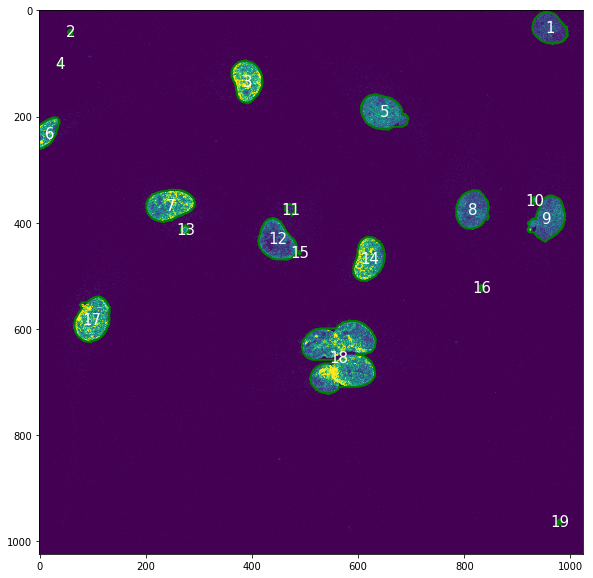

In [3]:
#Se muestra la imágen de todas las regiones detectadas mediante la utilización de funciones del módulo skimage
#Librerías utilizadas
from skimage.filters import threshold_li, threshold_minimum, threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import matplotlib.patches as mpatches

def fill_contours(arr):
    """Función para rellenar huecos internos dentro de un objeto detectado"""
    return (np.maximum.accumulate(arr,1) & np.maximum.accumulate(arr[:,::-1],1)[:,::-1])

fig, ax = plt.subplots(figsize=(10, 10))

image_grey = image

# Detectamos el límite propuesto por el método de Otsu y de Li
thresh = threshold_li(image_grey)
thresh_otsu = threshold_otsu(image_grey)

#Obtenemos los objetos detectados en la imagen eliminando el fondo -utilizando el valor límite- y uniendo huecos de un pixel para obtener continuidad.
bw = closing(image_grey > thresh)
#bw = image_grey > thresh
# Etiquetamos los objetos detectados
label_image = label(bw)
region_image = label_image.copy()

#Contamos el número de nucleos detectados
cell_num=1
regions_above_noise = []
areas=[]
for region in regionprops(label_image, image_grey):
    #Sólo detectamos aquellos regiones con un mínimo de pixeles para poder ser considerado un núcleo
        if region.area >= 9:
            #Lista con las nuevas regiones
            areas.append(region.area)
            regions_above_noise.append(region)
            #Aislamos las regiones detectadas
            region_image[:,:] = 0
            region_image[label_image == region.label] = region.label
            #Rellenamos los posibles huecos internos
            region_image=fill_contours(region_image)
            #Se detectan los contornos de la región
            contours=skimage.measure.find_contours(region_image,0.5)
            #Marcamos en la imagen los contornos para la región detectada
            for n, contour in enumerate(contours):
                ax.plot(contour[:,1], contour[:,0],'g', linewidth=2)
            #Anotación de cada región 
            minr, minc, maxr, maxc = region.bbox
            ax.text(0.5*(minc+maxc),0.5*(minr+maxr), str(cell_num), horizontalalignment="center", verticalalignment="center", fontsize=15, color="white")
            cell_num+=1




median=np.median(areas)
ax.imshow(image_grey)
# El valor 13.7 es una constante. Dicha constante se obtiene al dividir la mediana de las areas de los
# núcleos celulares (utilizados en el entrenamiento de la CNN) por el número de pixeles utilizados en
# los parches que contenían dichos núcleos celulares.
# Mediana(Áreas ńucleos cél de entrenamiento)/(192*192) = 13.7

patch = int((13.7*median)**(0.5))
print("Number of regions: {}" .format(cell_num-1))#Número de regiones detectadas
print("Median area: {}" .format(median))# Mediana de las áreas de las regiones detectadas
print("Patch area: {}" .format(patch))# Área de los parches a generar para la clasificación de imágenes de núcleos celulares


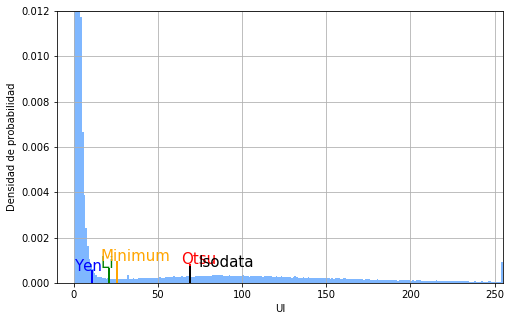

In [4]:

from skimage.filters import threshold_yen, threshold_li, threshold_isodata, threshold_minimum, threshold_otsu 

# Histograma de intensidades. Se muestran los valores límites de segmentación mediante la útilización de varios métodos.
ib_1d = image_grey.ravel()
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[8,5])
a,b,c=ax.hist(ib_1d, bins=255, density= True, alpha=0.5, color="#0070FF")
plt.plot([threshold_otsu(image_grey), threshold_otsu(image_grey)], [0, 0.0008],"red", lw=2)
plt.text(threshold_otsu(image_grey)-5,0.00085, 'Otsu', fontsize=15, color="red")
plt.axis([-10, 255, 0, 0.012])

plt.plot([threshold_li(image_grey), threshold_li(image_grey)], [0, 0.0006],"green", lw=2)
plt.text(threshold_li(image_grey)-5,0.00065, 'Li ', fontsize=15, color="green")

plt.plot([threshold_yen(image_grey), threshold_yen(image_grey)], [0, 0.0005],"blue", lw=2)
plt.text(threshold_yen(image_grey)-10,0.00055, 'Yen', fontsize=15, color="blue")

plt.plot([threshold_isodata(image_grey), threshold_isodata(image_grey)], [0, 0.0007],"black", lw=2)
plt.text(threshold_isodata(image_grey)+5,0.0007, 'Isodata', fontsize=15, color="black")

plt.plot([threshold_minimum(image_grey), threshold_minimum(image_grey)], [0, 0.0009],"orange", lw=2)
plt.text(threshold_minimum(image_grey)-10,0.00095, 'Minimum', fontsize=15, color="orange")


plt.grid(True)
#Anotación
ax.set_ylabel("Densidad de probabilidad")
ax.set_xlabel("UI")


plt.show()


In [5]:
#Generamos los parches con núcleos celulares para posteriormente ser clasificados
from PIL import Image
from skimage.transform import resize
def Generate_patches(im_grey, box):
    """
    Se realiza la segmentación inicial y se generan parches de núcleos celulares.
    """
    input_shape = im_grey.shape
    # Eliminamos el fondo de la imagen mediante el metodo de Li
    thresh = threshold_li(im_grey)
    #Obtenemos los objetos detectados en la imagen eliminando el fondo -utilizando el valor limite- y uniendo huecos de un pixel para obtener continuidad.
    bw = closing(im_grey > thresh, square(3))

    # Etiquetamos los objetos detectados
    label_image = label(bw)
    region_image = label_image.copy()
    cell_num=1
    regions_above_noise = []
    for region in regionprops(label_image, im_grey):
        if region.area > 9:#Solo detectamos aquellos regiones de color azul con un minimo de pixeles para poder ser considerado un nucleo
            #Lista con las nuevas regiones
            regions_above_noise.append(region)
            #Aislamos las regiones detectadas
            region_image[:,:] = 0
            region_image[label_image == region.label] = region.label
            #Rellenamos los posibles huecos internos
            region_image=fill_contours(region_image)
            
            region_image[region_image != 0] = im_grey[region_image != 0]
            centre=region.centroid
            bbox = [(int(centre[0]-box/2)),(int(centre[0]+box/2)),(int(centre[1]-box/2)),(int(centre[1]+box/2))]
        
            for i,j in enumerate(bbox):
                if j<0:
                    bbox[i+1]=box
                    bbox[i]=0
                if j>input_shape[0] and i==1:
                    bbox[i-1]=input_shape[0]-box
                    bbox[i]=input_shape[0]
                if j>input_shape[1] and i==3:
                    bbox[i-1]=input_shape[1]-box
                    bbox[i]=input_shape[1]
                    
                    
            cell_num+=1
            sel_cel = region_image[bbox[0]:bbox[1],bbox[2]:bbox[3]]
            
            
            sel_cel=resize(sel_cel, (192,192), mode="symmetric", preserve_range=True)
            sel_cel = sel_cel*255/sel_cel.max()
            #sel_cel = sel_cel*255
            col_sel_cel=np.matrix(sel_cel, "uint8")
            img=Image.fromarray(col_sel_cel)
            img.save("".join(["./Data/tmp/samples/",str(cell_num+1000000),".tif"]))
            plt.close("all")
    return (regions_above_noise, label_image)
sp.call([" ".join(["rm","./Data/tmp/samples/*"])], shell=True)#Borramos los archivos temporales
regions_above_noise, label_image=Generate_patches(image_grey,patch)


In [6]:
#Cargamos las librerias de Keras
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as k



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
#Clasificación de los parches generados mediante CNN (arquitectura pre-entrenada VGG16)
def CNN_inference(dim_patch, num_regions):
    nb_classes = 3
    img_width, img_height = dim_patch,dim_patch
    batch_size=32
    n=32
    samples_data_dir = './Data/tmp'
    model_pretrained='./Data/weights/model_weights.h5'
    base_model = VGG16( input_shape=(192, 192, 3),weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(base_model.input, predictions)
    model.load_weights(model_pretrained)

    predict_data = ImageDataGenerator(rescale=1. / 255)
    validation_generator = predict_data.flow_from_directory(samples_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode=None,
                                                        shuffle= False)
    
    predictions = model.predict_generator(validation_generator)
    predictions = predictions.argmax(axis=1).tolist()
    
    return (predictions)

predictions = CNN_inference(192,len(regions_above_noise))
print(predictions)

Found 19 images belonging to 1 classes.
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0]


In [8]:
#Quitamos las regiones de restos celulares y otras regiones no nucleares
regions_without_debris = [j for i,j in enumerate(regions_above_noise) if  predictions[i]>0]
predictions=[i for i in predictions if i!=0]

In [9]:
#Conservamos las regiones
cluster_regions = [j for i,j in enumerate(regions_without_debris) if  predictions[i]==2 ]
unicell_regions = [i for i in regions_without_debris if i not in cluster_regions]
print(len(regions_without_debris))
print(len(unicell_regions))
print(len(cluster_regions))



12
11
1


In [10]:
#Eliminamos los archivos temporales
sp.call([" ".join(["rm","./Data/tmp/samples/*"])], shell=True)

0

In [11]:
from scipy import ndimage as ndi
from skimage.morphology import closing, square
from skimage.morphology import watershed
from skimage.feature import peak_local_max


def apply_watershed (binary_image, min_distance, raw_image):
    """
    Realiza una segmentación watershed a la imagen binaria (binary_image). Sólo se formaran máximos locales siempre
    que exista una distancia mayor a min_distance entre máximos locales.
    """
    distance = ndi.distance_transform_edt(binary_image)
    local_maxi = peak_local_max(distance,
                                indices=False, 
                                labels=binary_image,
                                min_distance=min_distance)
    markers = ndi.label(local_maxi)[0]
    label_image = watershed(-distance, markers=markers, mask=binary_image)
    label_image *= binary_image
    regions = regionprops(label_image, raw_image)
    return (regions, label_image)



In [12]:
def Generate_patches(regions, box,label_image,im_grey, cell_num=0):
    """
    Se generan los parches con núcleos celulares
    """
    input_shape = im_grey.shape
    region_image = label_image.copy()
    #cell_num = 0
    for region in regions:
        region_image[:,:] = 0
        region_image[label_image == region.label] = region.label
        region_image[region_image != 0] = im_grey[region_image != 0]
        centre=region.centroid
        bbox = [(int(centre[0]-box/2)),(int(centre[0]+box/2)),(int(centre[1]-box/2)),(int(centre[1]+box/2))]
        
        for i,j in enumerate(bbox):
            if j<0:
                bbox[i+1]=box
                bbox[i]=0
            if j>input_shape[0] and i==1:
                bbox[i-1]=input_shape[0]-box
                bbox[i]=input_shape[0]
            if j>input_shape[1] and i==3:
                bbox[i-1]=input_shape[1]-box
                bbox[i]=input_shape[1]
                    
                    
        cell_num+=1
        sel_cel = region_image[bbox[0]:bbox[1],bbox[2]:bbox[3]]
        sel_cel=resize(sel_cel, (192,192), mode="symmetric")
        sel_cel = sel_cel*255/sel_cel.max()
            
           
        col_sel_cel=np.matrix(sel_cel, "uint8")
        img=Image.fromarray(col_sel_cel)
        img.save("".join(["./Data/tmp/samples/",str(cell_num+1000000),".tif"]))
        plt.close("all")
    return 

In [13]:

#Se lleva a cabo la segmentación por watershed de los cluster de núcleos celulares no previamente segmentados.
threshold_step=range(int(thresh), int(thresh_otsu), abs(int((thresh_otsu-thresh)/5)))


radio=int((median/np.pi)**0.5) 
w=0
while w<len(threshold_step) and cluster_regions!=[]:
    region_image[:,:] = 0
    image_leftovers =region_image.copy()
    for h,j in enumerate(cluster_regions):
        region_image[label_image == j.label] = j.label
        image_leftovers[region_image != 0] = image_grey[region_image != 0]
        region_image[:,:] = 0
    
    bw = closing(image_leftovers > threshold_step[w], square(3))
    regions_splitted = apply_watershed(bw, radio,image_leftovers)[0]
    Generate_patches(regions_splitted,patch, apply_watershed(bw, radio,image_leftovers)[1],image_grey,cell_num=n*1000)
    label_image = apply_watershed(bw, radio,image_leftovers)[1]            
    predictions = CNN_inference(192,len(regions_splitted))
    
    print(predictions)
    
    unicell_regions+=[j for i, j in enumerate(regions_splitted) if predictions[i]==1 ]
    cluster_regions= [j for i,j in enumerate(regions_splitted) if predictions[i]==2]
    sp.call([" ".join(["rm","./Data/tmp/samples/*"])], shell=True)
    w+=1
    
    


Found 4 images belonging to 1 classes.
[1, 1, 1, 1]


In [14]:

#Si queda algún cluster de núcleos celulares sin segmentar se añade al grupo de regiones con un solo núcleo celular
unicell_regions+=cluster_regions


In [15]:
#Se vuelven a etiquetar todas las regiones con núcleos celulares
region_image[:,:] = 0
from random import shuffle
shuffle(unicell_regions)
for h,i in enumerate(unicell_regions):
    i.label=h+1
    for j in range(i.coords.shape[0]):
        region_image[i.coords[j,0],i.coords[j,1]]=i.label

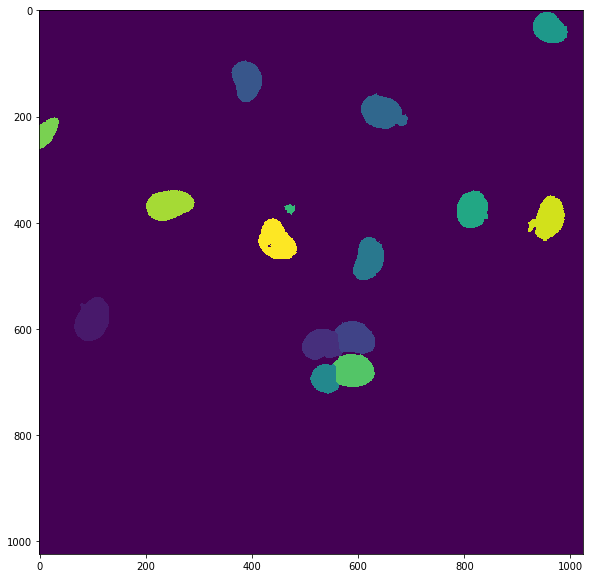

In [16]:
#Imagen de etiquetas de núcleos celulares detectados

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(region_image)

Number of cells: 15


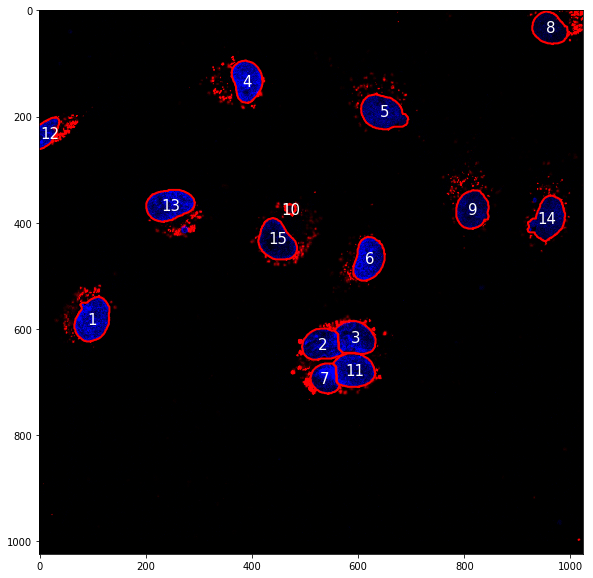

In [17]:
#Se genera la imagen con los núcleos detectados marcados en rojo
fig, ax = plt.subplots(figsize=(10, 10))
cell_num=1
label_image=region_image
region_image = label_image.copy()
for region in unicell_regions:
    #Sólo detectamos aquellos regiones con un mínimo de pixeles para poder ser considerado un núcleo
        if region.area >= 9:
            
            #Aislamos las regiones detectadas
            region_image[:,:] = 0
            region_image[label_image == region.label] = region.label
            #Rellenamos los posibles huecos internos
            region_image=fill_contours(region_image)
            #Se detectan los contornos de la región
            contours=skimage.measure.find_contours(region_image,0.5)
            #Marcamos en la imagen los contornos para la región detectada
            for n, contour in enumerate(contours):
                ax.plot(contour[:,1], contour[:,0],'r', linewidth=2)
            #Anotación de cada región 
            minr, minc, maxr, maxc = region.bbox
            ax.text(0.5*(minc+maxc),0.5*(minr+maxr), str(cell_num), horizontalalignment="center", verticalalignment="center", fontsize=15, color="white")
            cell_num+=1



image = io.imread(imaged)

ax.imshow(image)
print("Number of cells: {}" .format(cell_num-1))